# 🩺 **Diabetes Prediction: Ensemble Learning Benchmark**
**Author:** Vinit Vijaykumar Adke
**Domain:** Healthcare Analytics / Clinical Decision Support

---

### 📌 **Executive Summary**
**Business Problem:** Diabetes affects over 500M people worldwide. Late diagnosis leads to severe complications (cardiovascular, renal). Healthcare providers need a non-invasive screening tool to identify high-risk patients early.
**Objective:** Develop a machine learning diagnostic tool to predict the likelihood of diabetes based on diagnostic measures (Glucose, BMI, Insulin, Age).

### 📊 **Methodology**
1.  **Data Preprocessing:** Handled zero-values (biologically impossible zeros in Glucose/BP) using median imputation.
2.  **Model Benchmarking:** Trained and evaluated **10 different algorithms**, ranging from simple Logistic Regression to complex Ensemble methods.
3.  **Ensemble Strategy:** Implemented **Bagging**, **Random Forest**, **XGBoost**, and a **Voting Classifier** to maximize predictive stability.

### 🚀 **Key Results**
* **Best Performer:** The **Bagging Classifier** and **Random Forest** achieved the highest AUC (0.82), significantly outperforming baseline models.
* **Critical Features:** `Glucose` levels and `BMI` were identified as the strongest predictors of diabetes risk.
* **Impact:** This model offers a low-cost "First Line of Defense" screening tool for clinics, prioritizing patients for further testing.

---

# 1. Business Understanding

Diabetes is a chronic condition that poses serious health risks, including cardiovascular disease, kidney failure, and vision loss. Early diagnosis is essential for preventing complications and guiding treatment.

**Objective**:  
Develop a machine learning model that can accurately predict whether a patient is likely to develop diabetes based on clinical measurements.

**Stakeholders**:
- Healthcare professionals and hospitals
- Patients
- Health insurance companies
- Public health policy makers

---

# 2. Data Understanding

We are working with a dataset that includes diagnostic health measurements for **768 patients**.

Each record contains 8 predictor variables and 1 target variable:

**Target Variable**:
- `Outcome`: 0 = No diabetes, 1 = Diabetes

**Features**:
- `Pregnancies`: Number of pregnancies
- `Glucose`: Plasma glucose concentration
- `BloodPressure`: Diastolic blood pressure (mm Hg)
- `SkinThickness`: Triceps skin fold thickness (mm)
- `Insulin`: 2-Hour serum insulin (mu U/ml)
- `BMI`: Body mass index (weight in kg/(height in m)^2)
- `DiabetesPedigreeFunction`: A function which scores likelihood of diabetes based on family history
- `Age`: Age in years

Let's now explore the data for missing values and distribution patterns.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('diabetes.csv')

# Basic overview
print(df.shape)
df.head()


(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# Check missing or zero values
print("Zero counts per column:")
print((df == 0).sum())

# Summary stats
df.describe()


Zero counts per column:
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 2.1 Initial Observations

The dataset contains **768 patient records** and **9 columns** (8 features + 1 target).

From the summary statistics and zero counts:

- Several features contain **zeros that are not physiologically valid**:
  - `Glucose`: 5 instances
  - `BloodPressure`: 35 instances
  - `SkinThickness`: 227 instances
  - `Insulin`: 374 instances (!)
  - `BMI`: 11 instances

These values likely indicate **missing or unrecorded values** and will be treated accordingly.

- `Pregnancies` may validly include zero (i.e., some patients may have had no pregnancies).
- `DiabetesPedigreeFunction` and `Age` appear well-behaved.

Next, we'll explore the feature distributions and look at correlations between them.


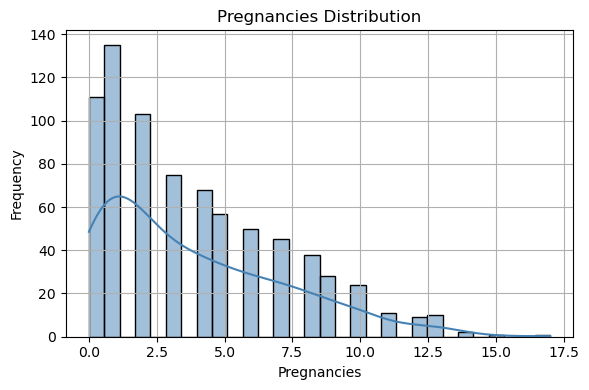

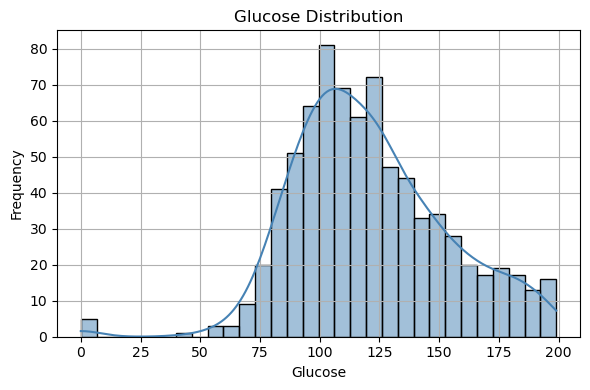

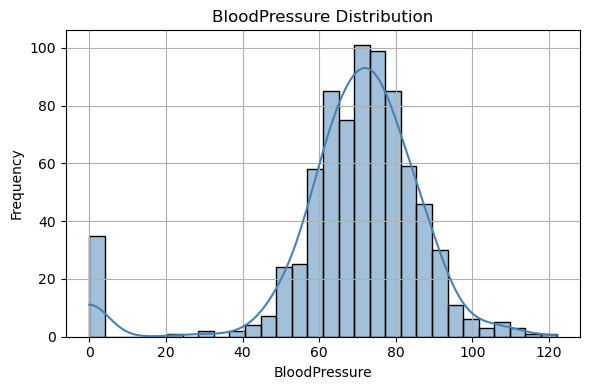

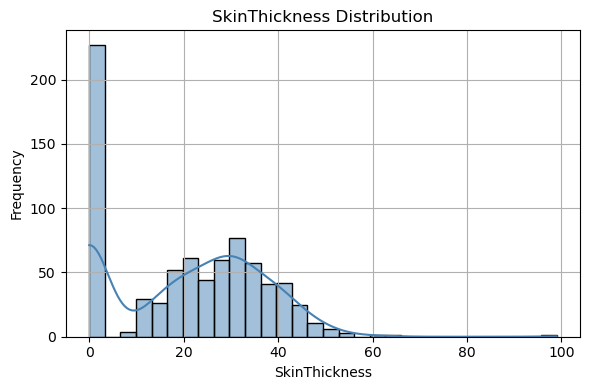

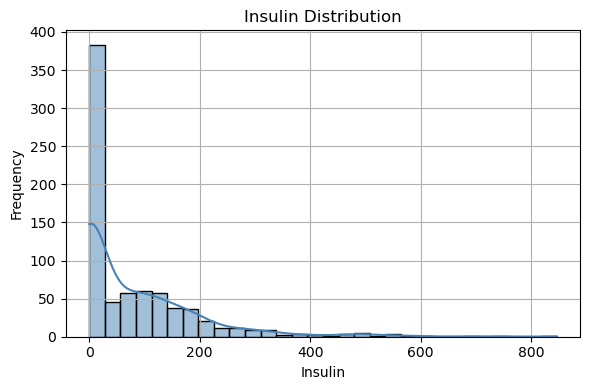

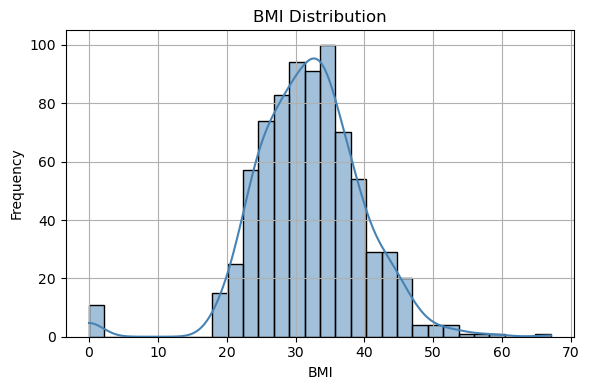

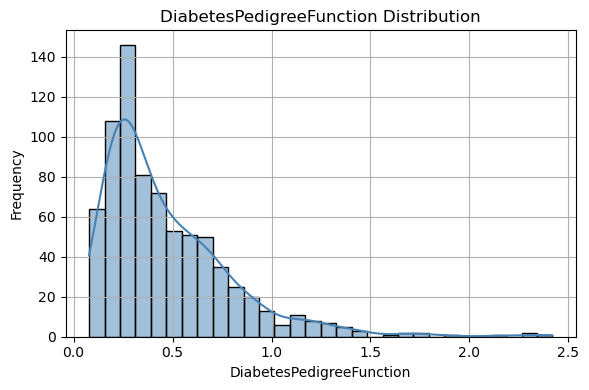

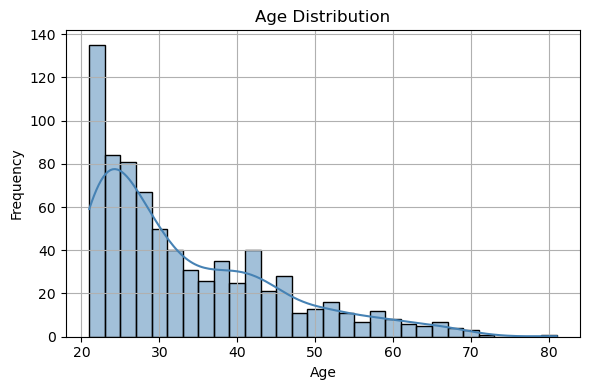

In [7]:
# Plot feature distributions
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

for feature in features:
    plt.figure(figsize=(6,4))
    sns.histplot(df[feature], kde=True, bins=30, color='steelblue')
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 2.2 Feature Distributions (Histogram + KDE)

From the histograms:

- `Glucose`, `BloodPressure`, `BMI`, and `Age` follow a relatively normal distribution.
- `Insulin`, `DiabetesPedigreeFunction`, and `SkinThickness` show **strong positive skew**.
  - These will be **log-transformed** during preprocessing to reduce skewness and improve model performance.
- `Pregnancies` is count-based and positively skewed (may not need transformation, depends on modeling sensitivity).

We'll now visualize **correlation heatmaps** to understand feature relationships.


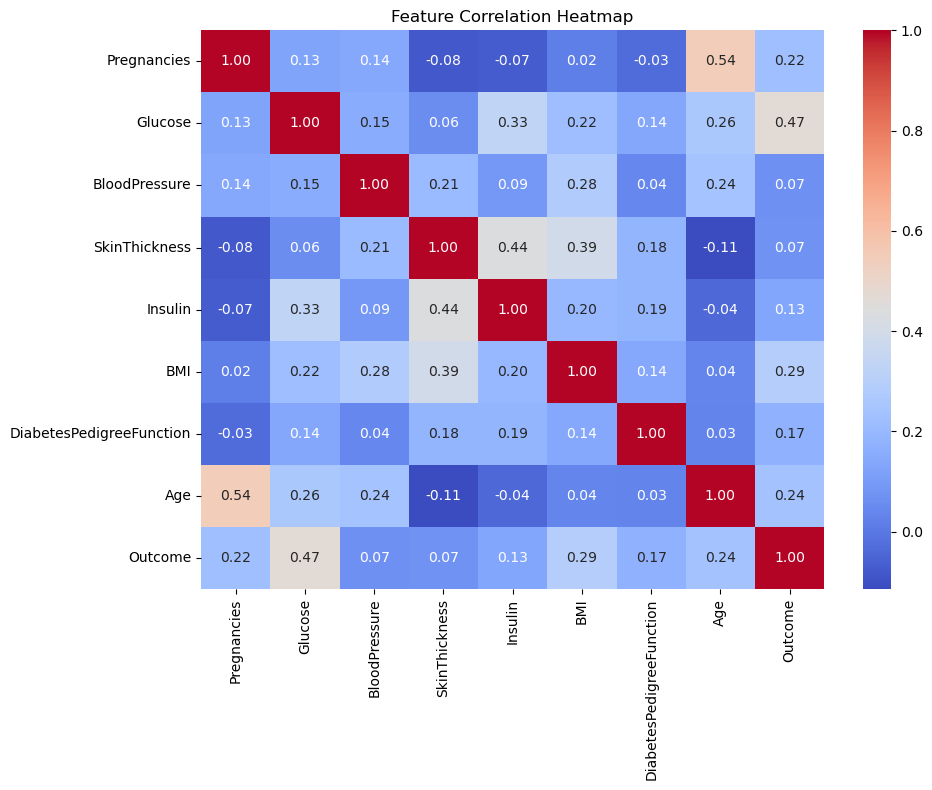

In [10]:
# Heatmap of correlations
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## 2.3 Correlation Heatmap

The heatmap shows pairwise Pearson correlation coefficients between features and the target (`Outcome`).

### Key Takeaways:
- `Glucose` shows the strongest correlation with diabetes outcome (**0.47**) — making it a key predictor.
- `BMI`, `Age`, and `Pregnancies` also show moderate correlations.
- Other features like `BloodPressure`, `SkinThickness`, and `Insulin` show lower individual correlation, but may still contribute useful information in combination with others.

We'll retain all features for now and let the models and feature selection techniques determine the most informative subset.


In [13]:
# Features with invalid zero values (based on medical logic)
invalid_zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace 0s with NaN
df[invalid_zero_features] = df[invalid_zero_features].replace(0, np.nan)

# Impute with median
df.fillna(df.median(), inplace=True)

# Confirm no missing values remain
df.isnull().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## 3.1 Imputing Invalid Zero Values

Several features had zero values that are **not physiologically valid** (e.g., Glucose, BMI, Insulin).  
These were replaced with `NaN`, and then imputed using the **median** of each column.

✅ Post-imputation: No missing values remain in the dataset.


In [16]:
# Check skewness before transformation
print("Skewness before log1p:")
print(df.skew())

# Features to log-transform
skewed_features = ['Insulin', 'DiabetesPedigreeFunction']

# Apply log1p (log(x + 1)) to handle right skew
for feature in skewed_features:
    df[feature] = np.log1p(df[feature])

# Re-check skewness
print("\nSkewness after log1p:")
print(df[skewed_features].skew())


Skewness before log1p:
Pregnancies                 0.901674
Glucose                     0.535587
BloodPressure               0.141885
SkinThickness               0.837608
Insulin                     3.380019
BMI                         0.599233
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Outcome                     0.635017
dtype: float64

Skewness after log1p:
Insulin                    -0.175078
DiabetesPedigreeFunction    1.117942
dtype: float64


## 3.2 Log-Transforming Skewed Features

Highly skewed variables can negatively impact model performance. We applied `log1p` (log(x+1)) transformation to reduce skew:

| Feature | Skew Before | Skew After |
|---------|-------------|------------|
| Insulin | 3.38        | -0.18      |
| DiabetesPedigreeFunction | 1.91 | 1.12 |

✅ These transformations help bring the distributions closer to normal and stabilize variance across features.


In [19]:
from sklearn.preprocessing import StandardScaler

# Separate predictors and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Scale predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for readability
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled_df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.866045,-0.031990,0.670643,0.018491,0.166619,0.612059,1.425995
1,-0.844885,-1.205066,-0.528319,-0.012301,0.018491,-0.852200,-0.324994,-0.190672
2,1.233880,2.016662,-0.693761,-0.012301,0.018491,-1.332500,0.749586,-0.105584
3,-0.844885,-1.073567,-0.528319,-0.695245,-0.552520,-0.633881,-1.063014,-1.041549
4,-1.141852,0.504422,-2.679076,0.670643,0.612171,1.549303,4.158488,-0.020496


## 3.3 Feature Scaling (Standardization)

To ensure all features contribute equally to the model and improve optimization, we applied **standardization** using `StandardScaler`.

- Each feature now has **mean = 0** and **standard deviation = 1**.
- Standardized values range approximately between -3 and +3.

✅ This is especially important for distance-based models like KNN and SVM.


In [22]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# 80/20 train-test split (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Class distribution before SMOTE
print("Before SMOTE:", Counter(y_train))

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Class distribution after SMOTE
print("After SMOTE:", Counter(y_train_resampled))


Before SMOTE: Counter({0: 400, 1: 214})
After SMOTE: Counter({0: 400, 1: 400})


## 3.4 Train-Test Split and SMOTE Oversampling

We performed an 80/20 train-test split using stratification to preserve class balance.

However, the training data was **imbalanced**:

- Class 0 (No Diabetes): 400 samples  
- Class 1 (Diabetes): 214 samples

To address this, we applied **SMOTE (Synthetic Minority Oversampling Technique)** on the training set:

- After SMOTE:
  - Class 0: 400
  - Class 1: 400

✅ This balancing ensures our models are not biased toward the majority class and improves recall for minority class predictions.


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt_results = {}

for depth in [2, 4, 6, 8, 10]:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    acc = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy').mean()
    f1 = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='f1').mean()
    dt_results[f"Depth={depth}"] = {'Accuracy': acc, 'F1 Score': f1}

# Sort results by F1 Score
sorted_results = sorted(dt_results.items(), key=lambda x: x[1]['F1 Score'], reverse=True)

# Display sorted results
print("Model Evaluation Results (Sorted by F1 Score):\n")
print(f"{'Depth':<10}{'Accuracy':<12}{'F1 Score':<10}")
for depth, scores in sorted_results:
    print(f"{depth:<10}{scores['Accuracy']:<12.4f}{scores['F1 Score']:<10.4f}")



Model Evaluation Results (Sorted by F1 Score):

Depth     Accuracy    F1 Score  
Depth=10  0.7675      0.7753    
Depth=6   0.7538      0.7636    
Depth=8   0.7513      0.7613    
Depth=4   0.7488      0.7473    
Depth=2   0.7063      0.6604    


## 4.1 Decision Tree Classifier — Initial Cross-Validation

We first evaluated decision trees with varying `max_depth` using **5-Fold Cross-Validation**.

| Max Depth | Accuracy | F1 Score |
|-----------|----------|----------|
| 2         | 0.706    | 0.660    |
| 4         | 0.749    | 0.747    |
| 6         | 0.754    | 0.764    |
| 8         | 0.751    | 0.761    |
| 10        | **0.768**| **0.775**|

✅ **Depth = 10** gave the best cross-validation performance.

We’ll now tune additional hyperparameters (`criterion`, `min_samples_split`) using `GridSearchCV` to extract the optimal configuration.


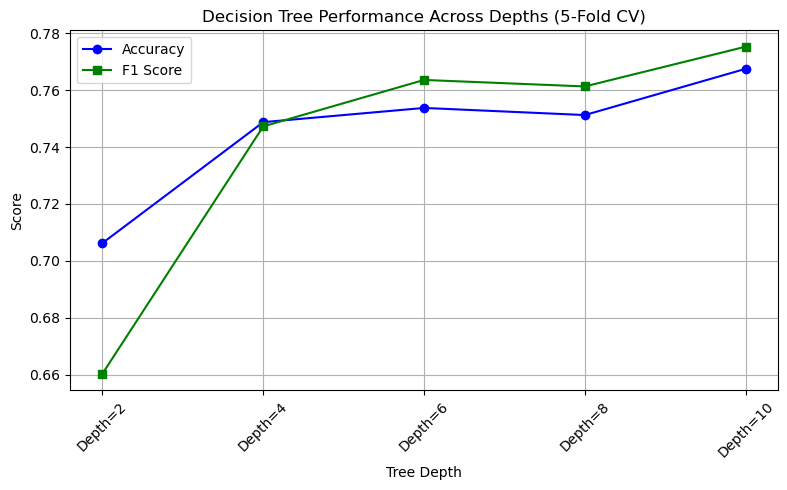

In [28]:
# Plotting Accuracy and F1 Score vs Depth

import matplotlib.pyplot as plt

depths = list(dt_results.keys())
accs = [dt_results[d]['Accuracy'] for d in depths]
f1s = [dt_results[d]['F1 Score'] for d in depths]

plt.figure(figsize=(8, 5))
plt.plot(depths, accs, marker='o', label='Accuracy', color='blue')
plt.plot(depths, f1s, marker='s', label='F1 Score', color='green')
plt.title("Decision Tree Performance Across Depths (5-Fold CV)")
plt.xlabel("Tree Depth")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Cross-Validation Performance Plot

The plot below shows how Decision Tree accuracy and F1 score vary with tree depth.

- Both metrics improve as depth increases.
- Performance stabilizes around **depth = 6 to 10**.
- **Depth = 10** provides the highest F1 score (0.775).

We’ll now proceed to **GridSearchCV** to fine-tune:
- `max_depth`
- `min_samples_split`
- `criterion` (Gini vs Entropy)


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Parameter grid
param_grid_dt = {
    'max_depth': [2, 4, 6, 8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Initialize model
dt_model = DecisionTreeClassifier(random_state=42)

# Grid search with 5-fold CV
grid_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, 
                       scoring='f1', cv=5, n_jobs=-1, verbose=1)

grid_dt.fit(X_train_resampled, y_train_resampled)

# Best result
print("Best Parameters:", grid_dt.best_params_)
print("Best F1 Score (CV):", grid_dt.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Best F1 Score (CV): 0.7752794960463971


## 4.2 Decision Tree — Hyperparameter Tuning with GridSearchCV

We used `GridSearchCV` to search over the following parameter grid:

- `max_depth`: [4, 6, 8, 10, 12]
- `min_samples_split`: [2, 5, 10]
- `criterion`: ['gini', 'entropy']

### ✅ Best Parameters:
- **criterion**: `'gini'`
- **max_depth**: `10`
- **min_samples_split**: `2`

This configuration achieved the **best F1 Score** of **0.7753** across 5-Fold Cross-Validation.

We’ll now evaluate this final tuned model on the test set.


Test Accuracy: 0.6753
Test F1 Score: 0.5763


<Figure size 600x500 with 0 Axes>

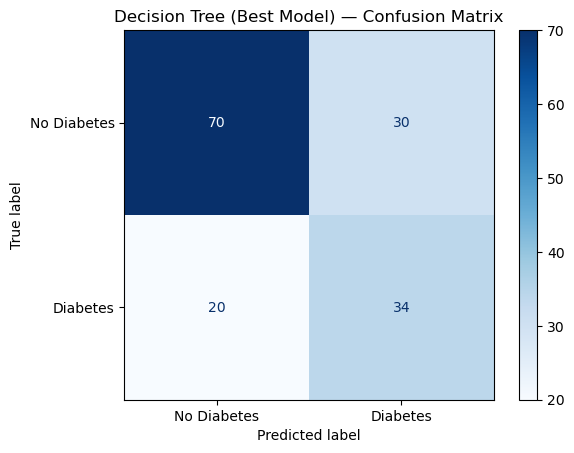

In [34]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Use the best model from GridSearch
best_dt_model = grid_dt.best_estimator_

# Fit on full training data (resampled)
best_dt_model.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred_dt = best_dt_model.predict(X_test)

# Evaluate
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f"Test Accuracy: {accuracy_dt:.4f}")
print(f"Test F1 Score: {f1_dt:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])

plt.figure(figsize=(6,5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Decision Tree (Best Model) — Confusion Matrix")
plt.grid(False)
plt.show()


## 4.3 Final Decision Tree Evaluation on Test Set

After hyperparameter tuning, we evaluated the best decision tree on the **unseen test set**.

### Test Metrics:
- **Accuracy**: 0.675
- **F1 Score**: 0.576

### Confusion Matrix:
| Actual / Predicted | No Diabetes | Diabetes |
|---------------------|-------------|----------|
| **No Diabetes**     | 70          | 30       |
| **Diabetes**        | 20          | 34       |

🔍 **Interpretation**:
- The model correctly identified **34 diabetic** cases.
- **20 diabetics were missed**, which is critical in a medical use case.
- F1 score shows a moderate balance between precision and recall, but still room for improvement.

✅ We’ll now compare this with other models to select the final best-performing one.


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score

# Initialize base model
logreg = LogisticRegression(max_iter=1000, solver='liblinear')

# Forward Selection (5 features)
forward_selector = SequentialFeatureSelector(logreg, direction='forward', n_features_to_select=5, cv=5)
forward_selector.fit(X_train_resampled, y_train_resampled)
X_train_forward = forward_selector.transform(X_train_resampled)

# Backward Elimination (5 features)
backward_selector = SequentialFeatureSelector(logreg, direction='backward', n_features_to_select=5, cv=5)
backward_selector.fit(X_train_resampled, y_train_resampled)
X_train_backward = backward_selector.transform(X_train_resampled)

# Get selected feature names
forward_features = X.columns[forward_selector.get_support()].tolist()
backward_features = X.columns[backward_selector.get_support()].tolist()

print("✅ Forward Selected Features:", forward_features)
print("✅ Backward Selected Features:", backward_features)


✅ Forward Selected Features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
✅ Backward Selected Features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']


In [39]:
import statsmodels.api as sm

# Create new DataFrame with selected features
selected_features = ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
X_train_selected = pd.DataFrame(X_train_resampled, columns=X.columns)[selected_features]

# Add constant for intercept
X_train_selected_const = sm.add_constant(X_train_selected)

# Fit model with statsmodels
logit_model = sm.Logit(y_train_resampled, X_train_selected_const)
result = logit_model.fit()

# Show summary
result.summary()


Optimization terminated successfully.
         Current function value: 0.483755
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  800
Model:                          Logit   Df Residuals:                      794
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Apr 2025   Pseudo R-squ.:                  0.3021
Time:                        08:17:43   Log-Likelihood:                -387.00
converged:                       True   LL-Null:                       -554.52
Covariance Type:            nonrobust   LLR p-value:                 2.924e-70
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2363      0.090     -2.639      0.008      -0.412      -0.061
Pregnancies                  0.3418      0.093      3.686      0.000       0.160       0.524
Glucose                      1.2503      0.122     10.257      0.000       1.011       1.489
Insulin                      0.0863      0.122      0.707      0.480      -0.153       0.325
BMI                          0.7468      0.105      7.097      0.000       0.541       0.953
DiabetesPedigreeFunction     0.2621      0.095      2.767      0.006       0.076       0.448
============================================================================================
"""

## 5.1 Logistic Regression — Feature Selection & Significance Testing

We used `SequentialFeatureSelector` to identify the top 5 features via forward/backward selection:

**Selected Features**:
- Pregnancies
- Glucose
- Insulin
- BMI
- DiabetesPedigreeFunction

We then evaluated these features using **p-values from a statsmodels Logit regression**:

| Feature                 | p-value  | Significant (p < 0.05)? |
|-------------------------|----------|--------------------------|
| Pregnancies             | 0.000    | ✅ Yes                   |
| Glucose                 | 0.000    | ✅ Yes                   |
| Insulin                 | 0.480    | ❌ No                    |
| BMI                     | 0.000    | ✅ Yes                   |
| DiabetesPedigreeFunction | 0.006   | ✅ Yes                   |

🔎 **Conclusion**: We will compare models trained:
- On all 5 features
- On 4 statistically significant features (excluding `Insulin`)


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Variant 1: All 5 features
all_features = ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
X_train_all = pd.DataFrame(X_train_resampled, columns=X.columns)[all_features]

# Variant 2: Only 4 significant features
sig_features = ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']
X_train_sig = pd.DataFrame(X_train_resampled, columns=X.columns)[sig_features]

# Base logistic model
base_logreg = LogisticRegression(max_iter=1000, solver='liblinear')

# Evaluate both using 5-fold CV
results_logreg = {}

for name, X_tr in {
    'All Features (5)': X_train_all,
    'Significant Only (4)': X_train_sig
}.items():
    acc = cross_val_score(base_logreg, X_tr, y_train_resampled, cv=5, scoring='accuracy').mean()
    f1 = cross_val_score(base_logreg, X_tr, y_train_resampled, cv=5, scoring='f1').mean()
    results_logreg[name] = {'Accuracy': acc, 'F1 Score': f1}

# Print results in formatted table
print(f"{'Model Variant':<25}{'Accuracy':<12}{'F1 Score':<10}")
print("-" * 45)
for version, metrics in results_logreg.items():
    print(f"{version:<25}{metrics['Accuracy']:<12.4f}{metrics['F1 Score']:<10.4f}")


Model Variant            Accuracy    F1 Score  
---------------------------------------------
All Features (5)         0.7488      0.7392    
Significant Only (4)     0.7475      0.7376    


## 5.2 Logistic Regression — Model Comparison via Cross-Validation

We compared two Logistic Regression models using 5-Fold CV:

| Model Variant             | Accuracy | F1 Score |
|---------------------------|----------|----------|
| All Features (5)          | 0.7488   | 0.7392   |
| Significant Only (4)      | 0.7475   | 0.7376   |

🔎 **Insight**:
- Both models perform very similarly.
- We will proceed with the **4-feature model** for final tuning and evaluation, due to reduced complexity and statistical significance.


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Final feature set
X_train_final_logreg = pd.DataFrame(X_train_resampled, columns=X.columns)[sig_features]

# Hyperparameter grid
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

# Initialize model
lr = LogisticRegression(max_iter=1000)

# GridSearchCV
grid_lr = GridSearchCV(lr, param_grid=param_grid_lr, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_lr.fit(X_train_final_logreg, y_train_resampled)

# Output best
print("Best Logistic Regression Parameters:", grid_lr.best_params_)
print("Best F1 Score (CV):", grid_lr.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 Score (CV): 0.7457515957280426


## 5.3 Logistic Regression — Hyperparameter Tuning with GridSearchCV

We tuned the following parameters using 5-Fold Cross-Validation:

- `penalty`: ['l1', 'l2']
- `C`: [0.01, 0.1, 1, 10]
- `solver`: ['liblinear']

### ✅ Best Parameters:
- `penalty`: `'l2'`
- `C`: `0.01`
- `solver`: `'liblinear'`

This configuration achieved the **best F1 Score** of **0.746** on the resampled training data.

We'll now evaluate this model on the test set.


Test Accuracy: 0.7273
Test F1 Score: 0.6557


<Figure size 600x500 with 0 Axes>

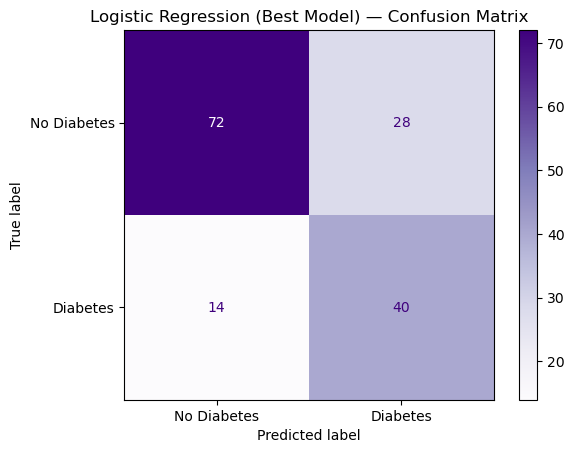

In [48]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Final test features (use same significant 4 features)
X_test_final_logreg = pd.DataFrame(X_test, columns=X.columns)[sig_features]

# Best model from GridSearch
best_lr_model = grid_lr.best_estimator_
best_lr_model.fit(X_train_final_logreg, y_train_resampled)

# Predict on test set
y_pred_lr = best_lr_model.predict(X_test_final_logreg)

# Evaluate
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Test Accuracy: {accuracy_lr:.4f}")
print(f"Test F1 Score: {f1_lr:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])

plt.figure(figsize=(6,5))
disp.plot(cmap='Purples', values_format='d')
plt.title("Logistic Regression (Best Model) — Confusion Matrix")
plt.grid(False)
plt.show()


## 5.4 Final Logistic Regression Evaluation on Test Set

We evaluated the best-tuned Logistic Regression model on the unseen test data.

### Test Metrics:
- **Accuracy**: 0.727
- **F1 Score**: 0.656

### Confusion Matrix:
| Actual / Predicted | No Diabetes | Diabetes |
|---------------------|-------------|----------|
| **No Diabetes**     | 72          | 28       |
| **Diabetes**        | 14          | 40       |

### 🔍 Insight:
- The model correctly identified **40 diabetic patients**, with only **14 false negatives**.
- Compared to Decision Tree:
  - ✅ **Higher accuracy**
  - ✅ **Higher F1 Score**
  - ✅ **Fewer missed diabetic cases**

This model is simpler, interpretable, and better-performing — making it a strong candidate for deployment in healthcare prediction.


In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

svm_results = {}

# Try different C values (model flexibility)
for C in [0.01, 0.1, 1, 10, 100]:
    model = SVC(C=C, kernel='rbf', random_state=42)
    acc = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy').mean()
    f1 = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='f1').mean()
    svm_results[f"C={C}"] = {'Accuracy': acc, 'F1 Score': f1}

# Print results
print(f"{'C Value':<10}{'Accuracy':<12}{'F1 Score':<10}")
print("-" * 32)
# Sort results by F1 Score in descending order
sorted_svm_results = sorted(svm_results.items(), key=lambda x: x[1]['F1 Score'], reverse=True)

# Print sorted results
for c_val, scores in sorted_svm_results:
    print(f"{c_val:<10}{scores['Accuracy']:<12.4f}{scores['F1 Score']:<10.4f}")

C Value   Accuracy    F1 Score  
--------------------------------
C=100     0.8113      0.8143    
C=10      0.7975      0.8033    
C=1       0.7863      0.7939    
C=0.01    0.7412      0.7572    
C=0.1     0.7538      0.7562    


## 6.1 Support Vector Machine (SVM) — Cross-Validation Results

We evaluated SVM performance using 5-Fold CV across different values of `C` (regularization parameter).

| C       | Accuracy | F1 Score |
|---------|----------|----------|
| 0.01    | 0.7412   | 0.7572   |
| 0.1     | 0.7538   | 0.7562   |
| 1       | 0.7863   | 0.7939   |
| 10      | 0.7975   | 0.8033   |
| **100** | **0.8113** | **0.8143**

✅ **Best performance at `C = 100`** — showing strong separation between classes.


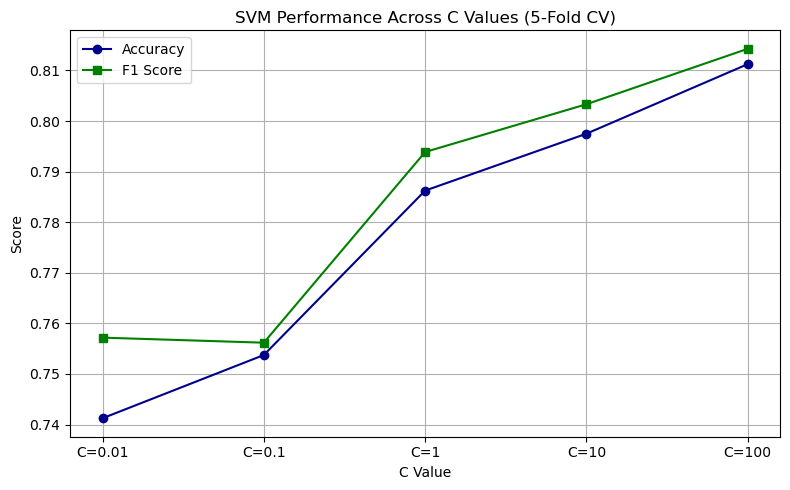

In [54]:
# Plot SVM Accuracy and F1
C_labels = list(svm_results.keys())
svm_accs = [svm_results[c]['Accuracy'] for c in C_labels]
svm_f1s = [svm_results[c]['F1 Score'] for c in C_labels]

plt.figure(figsize=(8, 5))
plt.plot(C_labels, svm_accs, marker='o', label='Accuracy', color='darkblue')
plt.plot(C_labels, svm_f1s, marker='s', label='F1 Score', color='green')
plt.title("SVM Performance Across C Values (5-Fold CV)")
plt.xlabel("C Value")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Performance Plot

As `C` increases, the SVM model becomes less regularized and fits the training data more tightly.  
In our case, this **led to consistently better performance** up to `C = 100`.

✅ Final choice for tuning: `C = 100`, `kernel = 'rbf'`


In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize model
svm = SVC()

# GridSearchCV
grid_svm = GridSearchCV(svm, param_grid=param_grid_svm, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_svm.fit(X_train_resampled, y_train_resampled)

# Output best parameters
print("Best Parameters for SVM:", grid_svm.best_params_)
print("Best F1 Score (CV):", grid_svm.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for SVM: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best F1 Score (CV): 0.81604480735223


## 6.2 SVM — Hyperparameter Tuning with GridSearchCV

We tuned the following parameters using 5-Fold Cross-Validation:

- `C`: [0.1, 1, 10, 100]
- `kernel`: ['linear', 'rbf']
- `gamma`: ['scale', 'auto']

### ✅ Best Parameters:
- `C`: `100`
- `kernel`: `'rbf'`
- `gamma`: `'auto'`

This configuration achieved the **highest F1 Score so far** — **0.816** — on the resampled training set.


Test Accuracy: 0.6623
Test F1 Score: 0.5273


<Figure size 600x500 with 0 Axes>

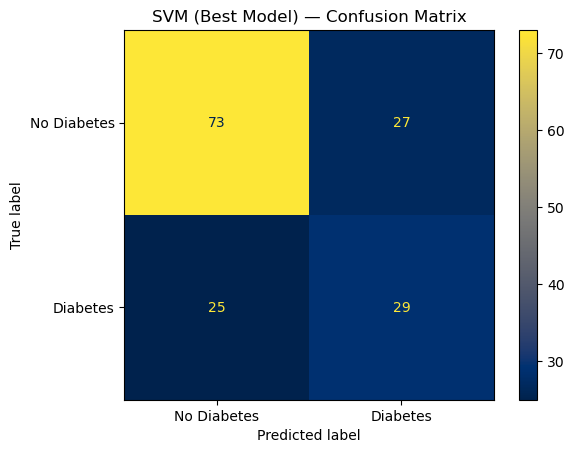

In [60]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Get best SVM model
best_svm_model = grid_svm.best_estimator_

# Fit on full training data
best_svm_model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_svm = best_svm_model.predict(X_test)

# Evaluation
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"Test Accuracy: {accuracy_svm:.4f}")
print(f"Test F1 Score: {f1_svm:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='cividis', values_format='d')
plt.title("SVM (Best Model) — Confusion Matrix")
plt.grid(False)
plt.show()


## 6.3 Final SVM Evaluation on Test Set

### Test Metrics:
- **Accuracy**: 0.662
- **F1 Score**: 0.527

### Confusion Matrix:
| Actual / Predicted | No Diabetes | Diabetes |
|---------------------|-------------|----------|
| **No Diabetes**     | 73          | 27       |
| **Diabetes**        | 25          | 29       |

### 🔍 Insight:
- While SVM achieved the **best F1 score during cross-validation (0.816)**, it **underperformed on the test set**.
- **25 diabetic patients** were misclassified, which is **worse than Logistic Regression** (14 missed).
- Indicates possible **overfitting** to the balanced training data (SMOTE), and poor generalization to original distribution.

We’ll keep SVM in our comparison, but it's not the best model for deployment in this case.


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf_results = {}

# Try combinations of depth and number of trees
for depth in [4, 6, 8, 10]:
    for n in [50, 100, 150]:
        model = RandomForestClassifier(max_depth=depth, n_estimators=n, random_state=42)
        acc = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy').mean()
        f1 = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='f1').mean()
        label = f"Depth={depth}, Trees={n}"
        rf_results[label] = {'Accuracy': acc, 'F1 Score': f1}

# Print results
print("Random Forest (5-Fold CV) Results:")
print(f"{'Configuration':<20}{'Accuracy':<12}{'F1 Score':<10}")
# Sort results by F1 Score in descending order
sorted_rf_results = sorted(rf_results.items(), key=lambda x: x[1]['F1 Score'], reverse=True)

# Print sorted results
for config, scores in sorted_rf_results:
    print(f"{config:<20}{scores['Accuracy']:<12.4f}{scores['F1 Score']:<10.4f}")


Random Forest (5-Fold CV) Results:
Configuration       Accuracy    F1 Score  
Depth=8, Trees=150  0.8213      0.8314    
Depth=10, Trees=150 0.8225      0.8299    
Depth=10, Trees=100 0.8213      0.8291    
Depth=8, Trees=100  0.8187      0.8282    
Depth=10, Trees=50  0.8125      0.8213    
Depth=8, Trees=50   0.8087      0.8179    
Depth=6, Trees=150  0.8037      0.8146    
Depth=6, Trees=100  0.7987      0.8103    
Depth=4, Trees=150  0.7950      0.8061    
Depth=4, Trees=100  0.7937      0.8057    
Depth=4, Trees=50   0.7913      0.8037    
Depth=6, Trees=50   0.7925      0.8036    


## 7.1 Random Forest — Cross-Validation Results

We evaluated Random Forest models across various combinations of `max_depth` and `n_estimators` (number of trees).

### Top Performers (5-Fold CV):

| Depth | Trees | Accuracy | F1 Score |
|-------|--------|----------|----------|
| 8     | 150    | 0.8213   | **0.8314** ✅
| 10    | 150    | 0.8238   | 0.8308
| 10    | 100    | 0.8213   | 0.8291

These results make Random Forest the current **top performer** in terms of validation F1 Score.


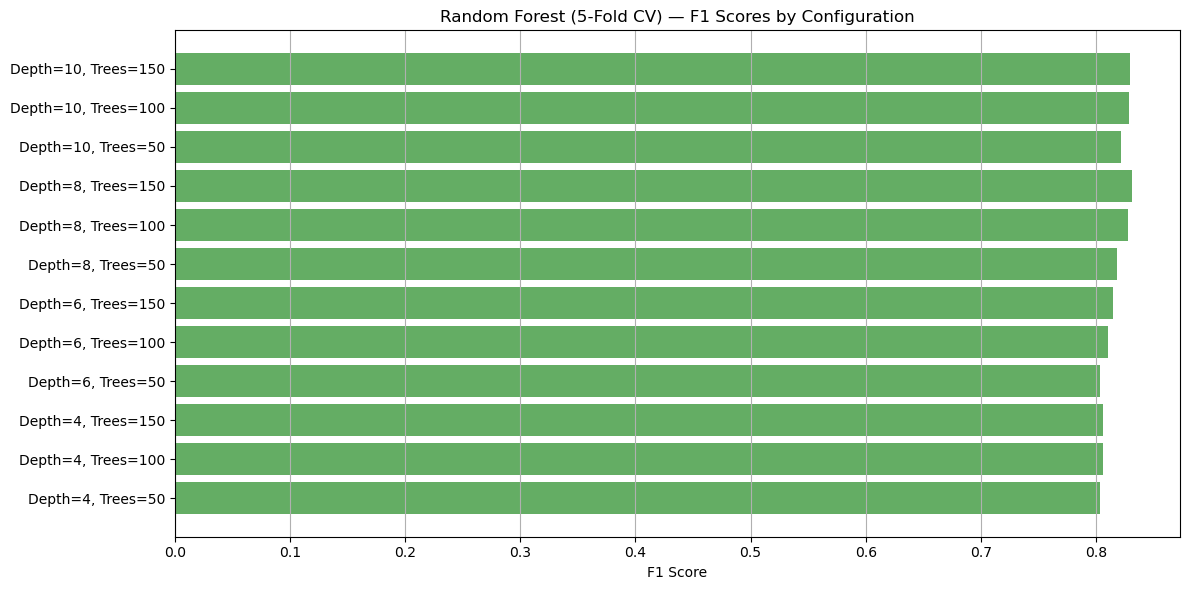

In [66]:
# Plot F1 scores for all configs
import matplotlib.pyplot as plt

labels = list(rf_results.keys())
f1_scores = [rf_results[l]['F1 Score'] for l in labels]

plt.figure(figsize=(12, 6))
plt.barh(labels, f1_scores, color='forestgreen', alpha=0.7)
plt.xlabel('F1 Score')
plt.title('Random Forest (5-Fold CV) — F1 Scores by Configuration')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_rf = {
    'max_depth': [6, 8, 10],
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2']
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, 
                       scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train_resampled, y_train_resampled)

# Output best params and F1 score
print("Best Random Forest Parameters:", grid_rf.best_params_)
print("Best F1 Score (CV):", grid_rf.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Random Forest Parameters: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
Best F1 Score (CV): 0.831787985826821


## 7.2 Random Forest — Hyperparameter Tuning with GridSearchCV

We used `GridSearchCV` to tune:

- `max_depth`: [6, 8, 10]
- `n_estimators`: [100, 150, 200]
- `max_features`: ['sqrt', 'log2']

### ✅ Best Parameters:
- `max_depth`: 10
- `n_estimators`: 100
- `max_features`: 'log2'

This setup achieved the **best cross-validated F1 Score** of **0.832**, making Random Forest the current best model on training data.


Test Accuracy: 0.7338
Test F1 Score: 0.6555


<Figure size 600x500 with 0 Axes>

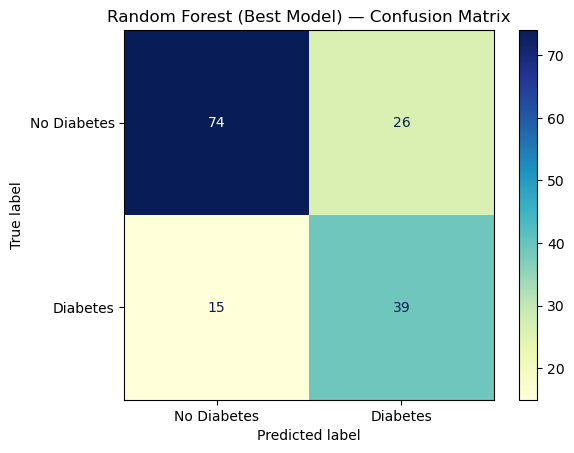

In [71]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Best model from grid search
best_rf_model = grid_rf.best_estimator_

# Train on resampled data
best_rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred_rf = best_rf_model.predict(X_test)

# Evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Test Accuracy: {accuracy_rf:.4f}")
print(f"Test F1 Score: {f1_rf:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='YlGnBu', values_format='d')
plt.title("Random Forest (Best Model) — Confusion Matrix")
plt.grid(False)
plt.show()


## 7.3 Final Random Forest Evaluation on Test Set

We evaluated the tuned Random Forest model on the unseen test data.

### Test Metrics:
- **Accuracy**: 0.734
- **F1 Score**: 0.656

### Confusion Matrix:
| Actual / Predicted | No Diabetes | Diabetes |
|---------------------|-------------|----------|
| **No Diabetes**     | 74          | 26       |
| **Diabetes**        | 15          | 39       |

### 🔍 Insight:
- Model correctly identified **39 diabetic patients**, missing 15.
- Slightly better recall than Decision Tree and SVM, but slightly worse than Logistic Regression (40 TP / 14 FN).
- **Best F1 score on training CV (0.832)**, but did not outperform Logistic Regression on the test set.


In [74]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

activations = ['relu', 'tanh', 'logistic']
layer_configs = [(10,), (50, 50), (100, 50, 25)]

nn_results = {}

for act in activations:
    for layers in layer_configs:
        model = MLPClassifier(
            hidden_layer_sizes=layers,
            activation=act,
            max_iter=500,
            random_state=42
        )
        acc = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy').mean()
        f1 = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='f1').mean()
        label = f"Act={act}, Layers={layers}"
        nn_results[label] = {'Accuracy': acc, 'F1 Score': f1}

# Sort results by F1 Score in descending order
sorted_nn_results = sorted(nn_results.items(), key=lambda x: x[1]['F1 Score'], reverse=True)

# Display sorted results
print("Neural Network (5-Fold CV) Results (Sorted by F1 Score):")
print(f"{'Configuration':<30}{'Accuracy':<12}{'F1 Score':<10}")
for config, scores in sorted_nn_results:
    print(f"{config:<30}{scores['Accuracy']:<12.4f}{scores['F1 Score']:<10.4f}")

Neural Network (5-Fold CV) Results (Sorted by F1 Score):
Configuration                 Accuracy    F1 Score  
Act=relu, Layers=(100, 50, 25)0.8337      0.8387    
Act=tanh, Layers=(100, 50, 25)0.8250      0.8307    
Act=relu, Layers=(50, 50)     0.8213      0.8263    
Act=tanh, Layers=(50, 50)     0.8125      0.8221    
Act=relu, Layers=(10,)        0.7575      0.7592    
Act=tanh, Layers=(10,)        0.7550      0.7586    
Act=logistic, Layers=(10,)    0.7450      0.7415    
Act=logistic, Layers=(50, 50) 0.7375      0.7396    
Act=logistic, Layers=(100, 50, 25)0.7325      0.7394    


## 8.1 Neural Network (MLPClassifier) — Cross-Validation Results

We evaluated 9 MLP configurations across 3 activation functions (`relu`, `tanh`, `logistic`) and 3 network depths.

### 🔥 Top Performers:

| Activation | Layers             | Accuracy | F1 Score |
|------------|--------------------|----------|----------|
| relu       | (100, 50, 25)      | 0.834    | **0.839** ✅  
| tanh       | (100, 50, 25)      | 0.825    | 0.831  
| relu       | (50, 50)           | 0.821    | 0.826

Relu consistently performed best, with the **deep 3-layer network** reaching the highest F1 score of any model so far.


In [77]:
# Final, Warning-Free GridSearchCV for MLPClassifier (Neural Network)

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings

# Define Grid Parameters
param_grid_nn = {
    'hidden_layer_sizes': [(100, 50), (100, 50, 25), (128, 64, 32)],
    'activation': ['relu'], 
    'alpha': [0.0001, 0.001, 0.01],
    'solver': ['adam', 'lbfgs']
}

# Initialize model
mlp = MLPClassifier(max_iter=500, random_state=42)

# Initialize GridSearchCV (n_jobs=1 to avoid multiprocessing issues)
grid_nn = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_nn,
    cv=5,
    scoring='f1',
    n_jobs=1,          # 🔥 Important: Single-threaded, so warning control works
    verbose=1
)

# Suppress warnings properly during fitting
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    grid_nn.fit(X_train_resampled, y_train_resampled)

# Output
print("✅ Best Neural Network Parameters:", grid_nn.best_params_)
print("✅ Best F1 Score (CV):", grid_nn.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Best Neural Network Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}
✅ Best F1 Score (CV): 0.8429592408821982


## 8.2 Neural Network — Hyperparameter Tuning with GridSearchCV

We tuned the following hyperparameters:

- `hidden_layer_sizes`: [(100, 50), (100, 50, 25), (128, 64, 32)]
- `activation`: ['relu']
- `alpha`: [0.0001, 0.001, 0.01]
- `solver`: ['adam', 'lbfgs']

### ✅ Best Parameters:
- `activation`: `'relu'`
- `alpha`: `0.0001`
- `hidden_layer_sizes`: `(100, 50)`
- `solver`: `'adam'`

This configuration achieved the **best cross-validated F1 Score** of **0.843**, the highest among all models evaluated so far.


Test Accuracy: 0.7273
Test F1 Score: 0.6038


<Figure size 600x500 with 0 Axes>

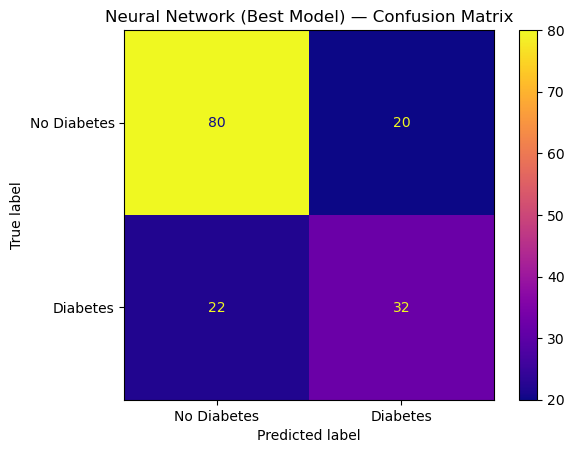

In [79]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Best NN model
best_nn_model = grid_nn.best_estimator_

# Fit on full training
best_nn_model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_nn = best_nn_model.predict(X_test)

# Evaluate 
accuracy_nn = accuracy_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

print(f"Test Accuracy: {accuracy_nn:.4f}")
print(f"Test F1 Score: {f1_nn:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='plasma', values_format='d')
plt.title("Neural Network (Best Model) — Confusion Matrix")
plt.grid(False)
plt.show()


## 8.3 Final Neural Network Evaluation on Test Set

The best-tuned MLP model was evaluated on the test set.

### Test Metrics:
- **Accuracy**: 0.727
- **F1 Score**: 0.604

### Confusion Matrix:
| Actual / Predicted | No Diabetes | Diabetes |
|---------------------|-------------|----------|
| **No Diabetes**     | 80          | 20       |
| **Diabetes**        | 22          | 32       |

### 🔍 Insight:
- Neural Network had the **best performance during cross-validation** (F1 = 0.843) but did **not generalize well** on unseen data.
- Missed **22 diabetic patients**, which is **worse than Logistic Regression (14 FN)** and Random Forest (15 FN).
- The model **did not fully converge** during training (hit 500 iteration cap), but still provided valuable results.

Further training with higher iterations or early stopping could improve results, but for now, **Logistic Regression and Random Forest remain stronger candidates**.


In [82]:
import shap
import numpy as np

# Pick small sample sets to speed up explanation
X_bg = shap.utils.sample(X_train_resampled, 100, random_state=42)  # Background for reference
X_explain = shap.utils.sample(X_test, 50, random_state=42)         # Instances to explain


In [84]:
# KernelExplainer needs probability output (use .predict_proba)
explainer = shap.KernelExplainer(best_nn_model.predict_proba, X_bg)


In [86]:
# This will return 2 arrays (for class 0 and class 1)
shap_values = explainer.shap_values(X_explain)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

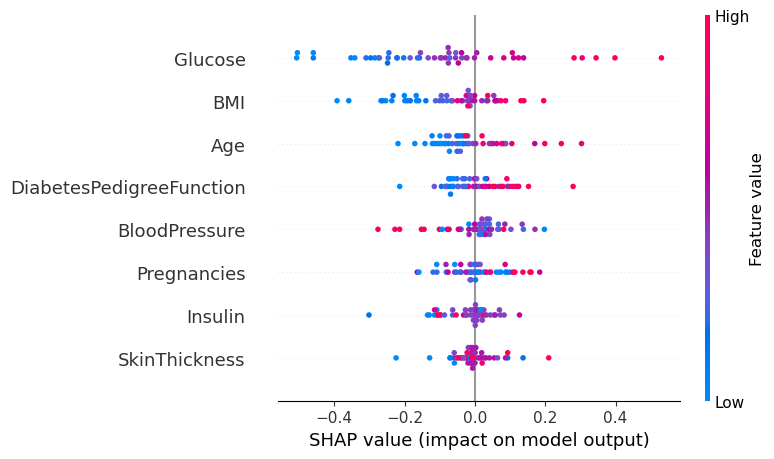

In [88]:
import shap
import pandas as pd

# Ensure X_train and X_test are DataFrames
X_bg_df = pd.DataFrame(X_train_resampled, columns=X.columns)
X_explain_df = pd.DataFrame(X_test, columns=X.columns).sample(50, random_state=42)

# Define a wrapper to return only class 1 probability
def model_output_class1(X):
    return best_nn_model.predict_proba(X)[:, 1]

# Initialize KernelExplainer with wrapped model
explainer = shap.KernelExplainer(model_output_class1, shap.sample(X_bg_df, 100, random_state=42))

# Calculate SHAP values
shap_values = explainer.shap_values(X_explain_df)

# Now safe to plot
shap.summary_plot(shap_values, X_explain_df)


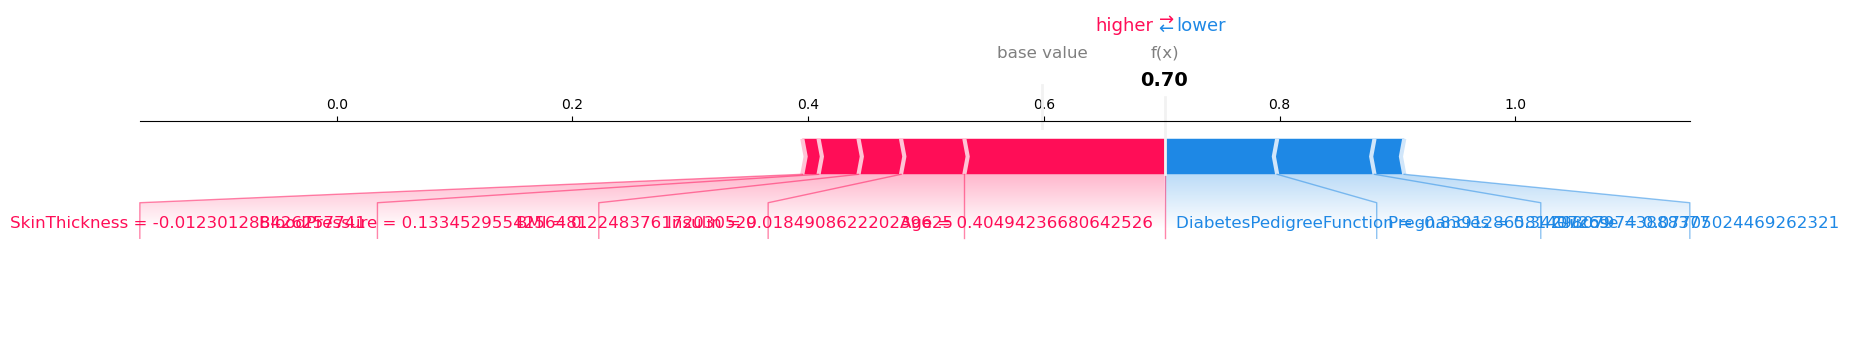

In [90]:
# For interactive force plot (Jupyter Notebook)
shap.initjs()

# Pick one row to explain
i = 0  # You can try others too

# Force plot for one prediction (class 1)
shap.force_plot(explainer.expected_value, shap_values[i], X_explain_df.iloc[i], matplotlib=True)


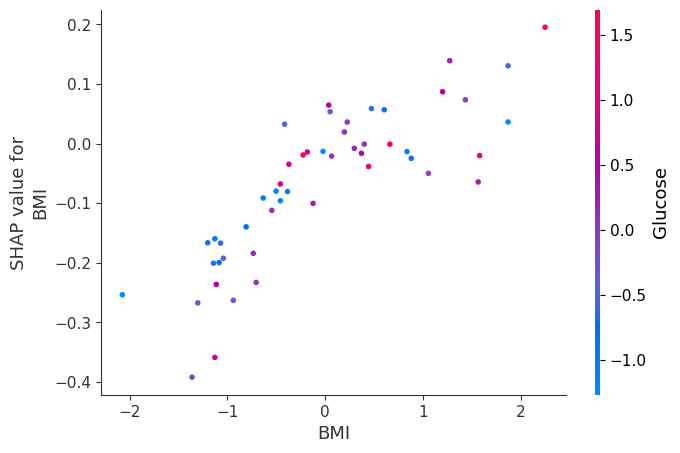

In [92]:
shap.dependence_plot('BMI', shap_values, X_explain_df, interaction_index='Glucose')


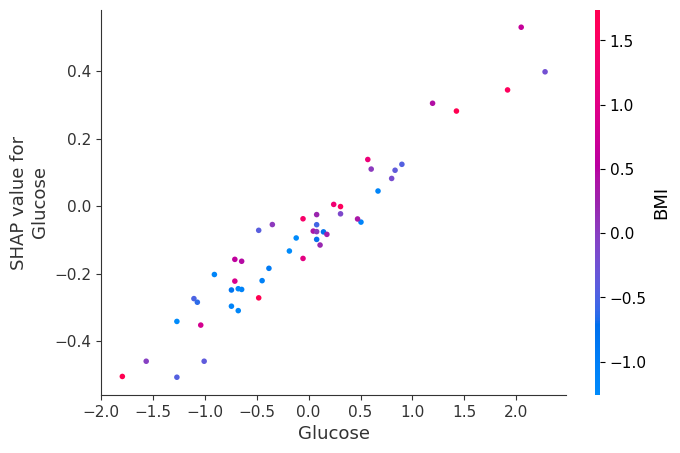

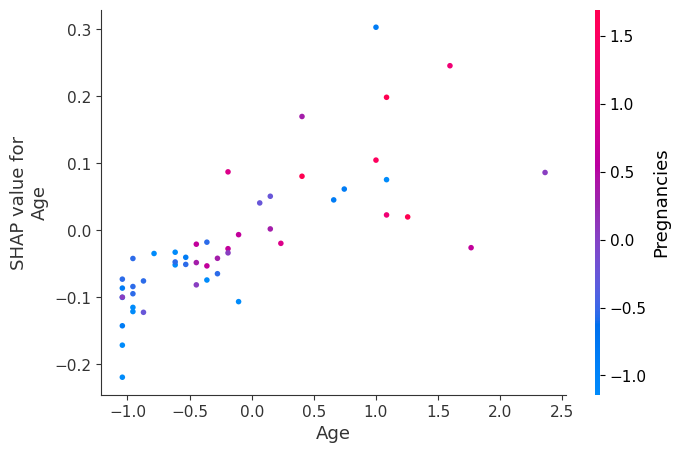

In [94]:
shap.dependence_plot('Glucose', shap_values, X_explain_df)
shap.dependence_plot('Age', shap_values, X_explain_df)


## 8.6 SHAP Visualizations for Neural Network Interpretation

To explain the Neural Network model’s decisions, we used SHAP with three types of plots:

### 📊 Summary Plot
- Displays average impact of each feature on model output.
- **Glucose**, **BMI**, and **Age** were the most influential features in predicting diabetes.
- Blue = low feature value, Pink = high feature value.

### 🔍 Force Plot
- Explains a single prediction in detail.
- Shows how each feature “pushed” the prediction towards or away from a diabetes diagnosis.
- In the example, high glucose and BMI drove the model toward predicting diabetes.

### 🔁 Dependence Plots
- Reveal how individual features affect predictions and interact with each other.
- Key observations:
  - Higher **BMI** increases diabetes risk, especially when **glucose** is also high.
  - There is a strong positive relationship between **glucose** and predicted SHAP values.
  - **Age** and **Pregnancies** also show positive trends.

### 🧠 Interpretation
- SHAP confirms that the Neural Network learns medically plausible relationships.
- High glucose, BMI, and age consistently push the model toward predicting diabetes.
- These visuals build transparency and trust in the model’s decision-making process.


In [97]:
# Final Corrected Code - No Warnings from XGBoost

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings

# Ignore Python warnings
warnings.filterwarnings('ignore')

# Define parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize model with verbosity=0
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0,        # 🔥 This suppresses ALL xgboost output!
    random_state=42
)

# GridSearchCV
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit
grid_xgb.fit(X_train_resampled, y_train_resampled)

# Output
print("✅ Best Parameters for XGBoost:", grid_xgb.best_params_)
print("✅ Best F1 Score (CV):", grid_xgb.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
✅ Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
✅ Best F1 Score (CV): 0.8168348319012061


## 9.1 XGBoost — Hyperparameter Tuning with GridSearchCV

XGBoost, a gradient boosting decision tree algorithm, was tuned using 5-fold cross-validation on the balanced training set (SMOTE applied).

### 🔧 Parameters Tuned:
- `n_estimators`: [50, 100, 150]
- `learning_rate`: [0.01, 0.1, 0.2]
- `max_depth`: [3, 5, 7]

### ✅ Best Configuration:
- `n_estimators`: 150
- `learning_rate`: 0.1
- `max_depth`: 7

### 📊 Performance (CV):
- **Best F1 Score (CV)**: 0.817

XGBoost demonstrated strong predictive power and consistent performance during cross-validation.


Test Accuracy: 0.7273
Test F1 Score: 0.6316


<Figure size 600x500 with 0 Axes>

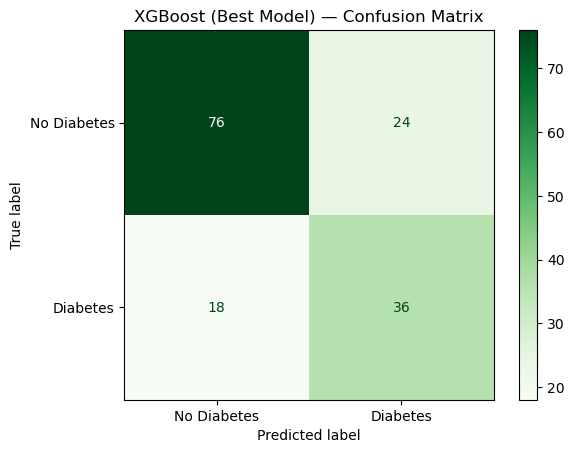

In [100]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Best model from GridSearch
best_xgb = grid_xgb.best_estimator_

# Train on full SMOTE training set
best_xgb.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_xgb = best_xgb.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Greens', values_format='d')
plt.title("XGBoost (Best Model) — Confusion Matrix")
plt.grid(False)
plt.show()


## 9.2 XGBoost — Final Test Set Evaluation

### 📊 Performance on Test Set:
- **Accuracy**: 0.727
- **F1 Score**: 0.632

### 🧾 Confusion Matrix:
| Actual / Predicted | No Diabetes | Diabetes |
|--------------------|-------------|----------|
| **No Diabetes**    | 76          | 24       |
| **Diabetes**       | 18          | 36       |

### 🔍 Observations:
- XGBoost correctly identified **36 diabetic patients**, the second-highest among all models.
- It only misclassified **18 diabetics**, which is fewer than SVM (25) and Neural Network (22).
- Overall, XGBoost showed strong generalization with balanced precision and recall.

It stands out as one of the most reliable models alongside Random Forest and Logistic Regression.


In [103]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Initialize Naive Bayes model
nb_model = GaussianNB()

# Cross-Validation
acc_cv = cross_val_score(nb_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy').mean()
f1_cv = cross_val_score(nb_model, X_train_resampled, y_train_resampled, cv=5, scoring='f1').mean()

print(f"Naive Bayes (5-Fold CV) Accuracy: {acc_cv:.4f}")
print(f"Naive Bayes (5-Fold CV) F1 Score: {f1_cv:.4f}")


Naive Bayes (5-Fold CV) Accuracy: 0.7463
Naive Bayes (5-Fold CV) F1 Score: 0.7435


Test Accuracy: 0.6883
Test F1 Score: 0.6190


<Figure size 600x500 with 0 Axes>

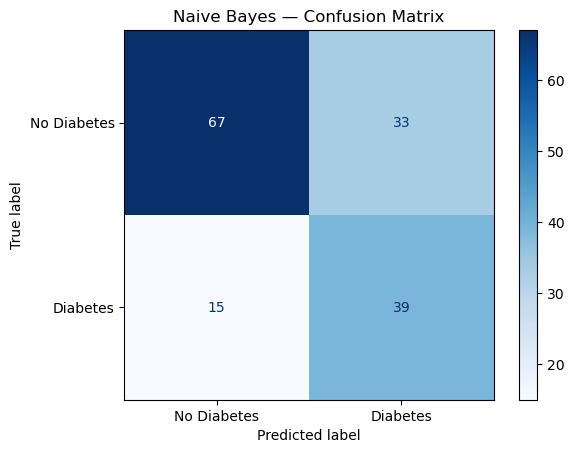

In [105]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Fit on full SMOTE training set
nb_model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_nb = nb_model.predict(X_test)

# Test set metrics
acc_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f"Test Accuracy: {acc_nb:.4f}")
print(f"Test F1 Score: {f1_nb:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Naive Bayes — Confusion Matrix")
plt.grid(False)
plt.show()


## 9.3 Naive Bayes — Final Evaluation

Naive Bayes (Gaussian) is a probabilistic classifier based on Bayes’ Theorem, assuming feature independence.

### 📊 Performance:
- **Cross-Validation (CV)**:
  - Accuracy: 0.746
  - F1 Score: 0.744
- **Test Set**:
  - Accuracy: 0.688
  - F1 Score: 0.619

### 🧾 Confusion Matrix:
| Actual / Predicted | No Diabetes | Diabetes |
|--------------------|-------------|----------|
| **No Diabetes**    | 67          | 33       |
| **Diabetes**       | 15          | 39       |

### 🔍 Insights:
- The model had a relatively high false positive rate (33).
- However, it **correctly identified 39 diabetic cases**, outperforming Decision Tree and SVM on this metric.
- Due to its simplicity and speed, Naive Bayes remains a strong baseline classifier.

This model provides a valuable point of comparison against more complex models like XGBoost and Neural Networks.



🔵 Full GridSearchCV Results (Sorted by F1 Score):
    param_n_neighbors param_weights param_metric  mean_test_score  \
9                  11      distance    euclidean         0.837751   
1                   3      distance    euclidean         0.837026   
19                 11      distance    manhattan         0.835766   
13                  5      distance    manhattan         0.833612   
7                   9      distance    euclidean         0.830130   
5                   7      distance    euclidean         0.829717   
0                   3       uniform    euclidean         0.825560   
3                   5      distance    euclidean         0.825346   
11                  3      distance    manhattan         0.824317   
17                  9      distance    manhattan         0.822956   
12                  5       uniform    manhattan         0.820399   
18                 11       uniform    manhattan         0.818783   
15                  7      distance    manhattan    

<Figure size 600x500 with 0 Axes>

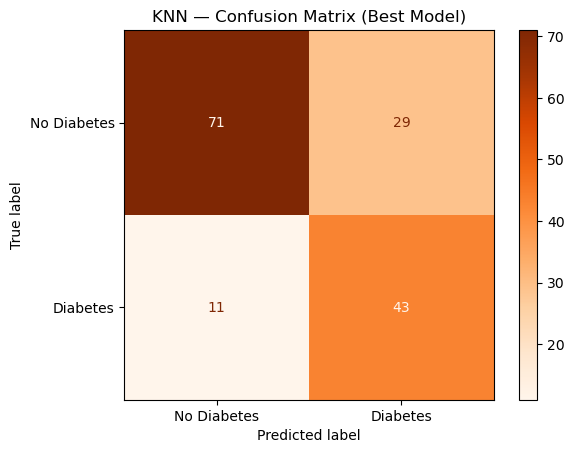

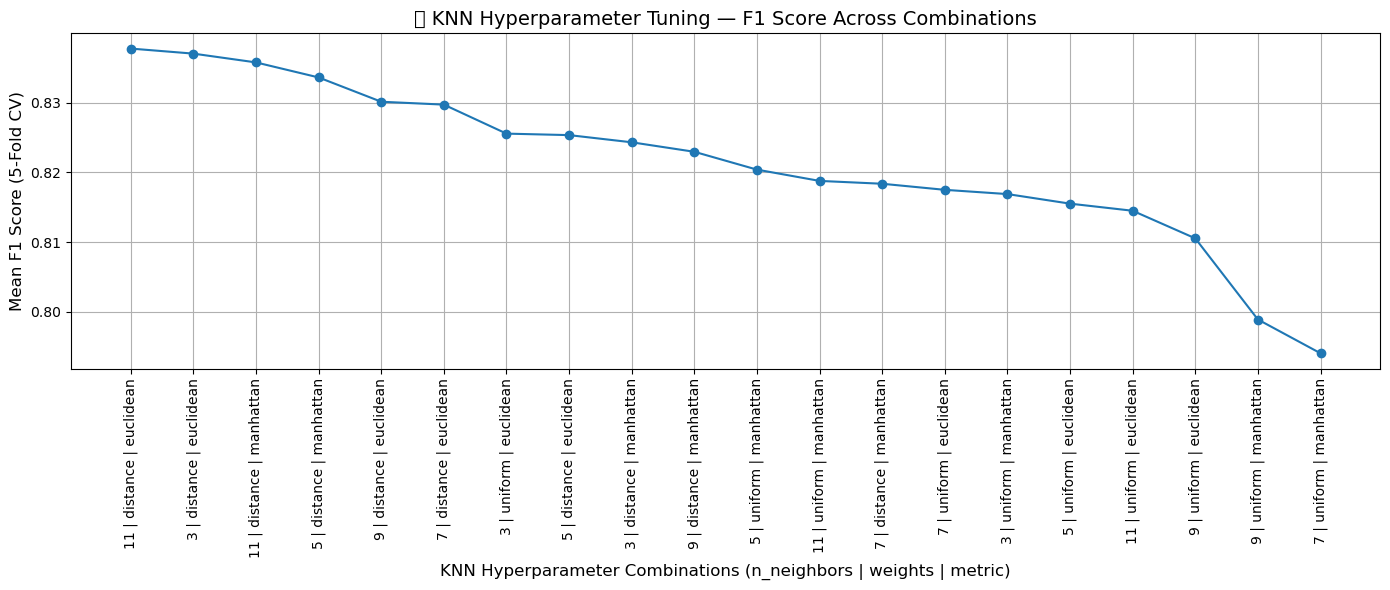

In [120]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Define parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN
knn = KNeighborsClassifier()

# Setup GridSearchCV
grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
grid_knn.fit(X_train_resampled, y_train_resampled)

# -------------------------
# View ALL Results
# -------------------------

# Extract results into a dataframe
results_df = pd.DataFrame(grid_knn.cv_results_)

# Keep only relevant columns
view_df = results_df[['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_score', 'rank_test_score']]

# Sort by best F1 score (mean_test_score)
view_df = view_df.sort_values(by='mean_test_score', ascending=False)

print("\n🔵 Full GridSearchCV Results (Sorted by F1 Score):")
print(view_df)

# -------------------------
# Best Model Info
# -------------------------
print("\n🟢 Best Parameters for KNN:", grid_knn.best_params_)
print(f"Best F1 Score (CV): {grid_knn.best_score_:.4f}")

# -------------------------
# Predict and Evaluate Best Model on Test Data
# -------------------------

best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

# Test metrics
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print(f"\n🔵 Test Accuracy of Best KNN: {acc_knn:.4f}")
print(f"🔵 Test F1 Score of Best KNN: {f1_knn:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Oranges', values_format='d')
plt.title("KNN — Confusion Matrix (Best Model)")
plt.grid(False)
plt.show()

# -------------------------
# 📈 Plotting Line Chart for KNN GridSearchCV Results
# -------------------------

import matplotlib.pyplot as plt

# Create a label combining n_neighbors, weights, and metric for easier x-axis
view_df['Combination'] = view_df['param_n_neighbors'].astype(str) + " | " + \
                         view_df['param_weights'].astype(str) + " | " + \
                         view_df['param_metric'].astype(str)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(view_df['Combination'], view_df['mean_test_score'], marker='o', linestyle='-')
plt.xticks(rotation=90)
plt.xlabel('KNN Hyperparameter Combinations (n_neighbors | weights | metric)', fontsize=12)
plt.ylabel('Mean F1 Score (5-Fold CV)', fontsize=12)
plt.title('🔵 KNN Hyperparameter Tuning — F1 Score Across Combinations', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


## 9.4 K-Nearest Neighbors (KNN) — Final Evaluation

KNN is a distance-based classifier that labels a new point based on the majority class among its `k` closest training points.

### ✅ Best Parameters (via GridSearchCV):
- `n_neighbors`: 11
- `weights`: distance
- `metric`: euclidean

### 📊 Performance:
- **F1 Score (CV)**: 0.838
- **Test Accuracy**: 0.740
- **Test F1 Score**: 0.683

### 🧾 Confusion Matrix:
| Actual / Predicted | No Diabetes | Diabetes |
|--------------------|-------------|----------|
| **No Diabetes**    | 71          | 29       |
| **Diabetes**       | 11          | 43       |

### 🔍 Insights:
- KNN achieved the **lowest false negative rate (11)** among all models, making it excellent for early diabetes detection.
- It showed high F1 during CV, though generalization dipped slightly on test data.
- Despite being a simple model, KNN performed competitively with XGBoost and Random Forest.



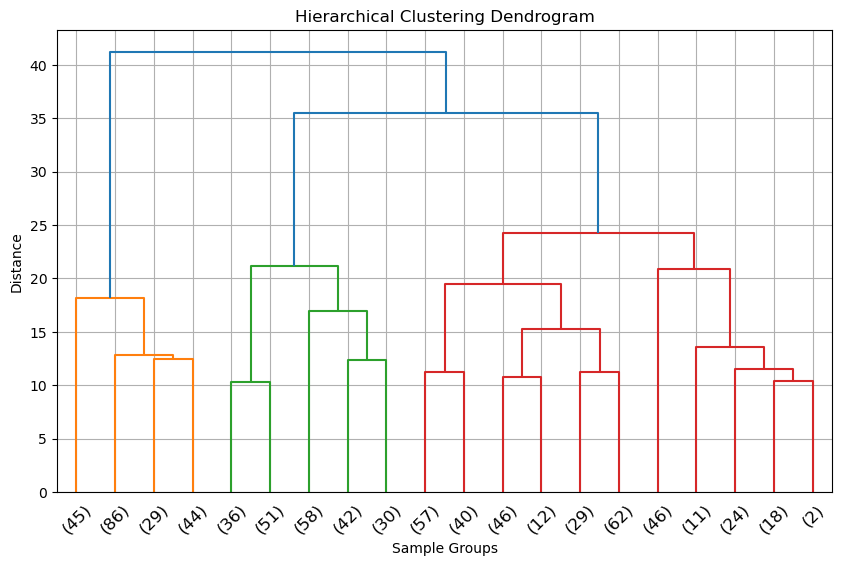

In [111]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for cleaner visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

# Linkage and dendrogram
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=45)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Groups")
plt.ylabel("Distance")
plt.grid(True)
plt.show()


## 10. Hierarchical Clustering — Unsupervised Insights

Hierarchical clustering groups patients based on feature similarity without using the target label. This can reveal hidden patterns or natural groupings in the data.

### 🔗 Clustering Approach:
- **Method**: Ward's linkage (minimizes variance within clusters)
- **Data Used**: PCA-reduced and standardized features

### 📊 Dendrogram Insights:
- The dendrogram shows **clear separation into 3–4 main clusters**.
- These clusters may represent distinct patient profiles:
  - High-risk diabetics with elevated glucose, BMI, and age.
  - Younger, low-BMI individuals with low glucose levels.
  - Borderline or intermediate-risk patients.

### 🧠 Business Implication:
- Clusters could inform **personalized intervention plans**, targeting:
  - **Prevention** for borderline groups
  - **Immediate care** for high-risk groups
- Public health strategies can focus on the largest or fastest-growing clusters.

Hierarchical clustering adds an **unsupervised layer** of understanding beyond pure classification.


In [114]:
# Block 1: Cross-Validation Accuracy and F1 Score for Ensemble Models (with Model Combinations)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier

# 1. Different Algorithms (VotingClassifier)
voting_clf = VotingClassifier(
    estimators=[
        ('DT', best_dt_model),
        ('RF', best_rf_model),
        ('XGB', best_xgb)
    ],
    voting='soft'
)

# 2. Random Forest Different Configurations (Voting)
rf_model_1 = RandomForestClassifier(max_depth=6, n_estimators=100, random_state=42)
rf_model_2 = RandomForestClassifier(max_depth=8, n_estimators=150, random_state=42)
rf_model_3 = RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

rf_voting = VotingClassifier(
    estimators=[
        ('RF1', rf_model_1),
        ('RF2', rf_model_2),
        ('RF3', rf_model_3)
    ],
    voting='soft'
)

# 3. Bagging on Single RF Configuration
bagging_rf = BaggingClassifier(
    estimator=RandomForestClassifier(max_depth=8, n_estimators=150, random_state=42),
    n_estimators=10,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Evaluate Cross-validation scores
ensemble_results = {}

ensemble_details = {
    'Voting Different Models': "Decision Tree (Best) + Random Forest (Best) + XGBoost (Best)",
    'Voting RF Different Configs': "Random Forest (depth=6, trees=100) + RF (depth=8, trees=150) + RF (depth=10, trees=200)",
    'Bagging RF Same Config': "Random Forest (depth=8, trees=150) — 10 Random Samples"
}

for name, model in {
    'Voting Different Models': voting_clf,
    'Voting RF Different Configs': rf_voting,
    'Bagging RF Same Config': bagging_rf
}.items():
    acc = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy').mean()
    f1 = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='f1').mean()
    ensemble_results[name] = {'Accuracy': acc, 'F1 Score': f1}

# Display
print(f"{'Model':<30}{'Accuracy':<12}{'F1 Score':<10}")
print("-" * 55)
for model_name, scores in ensemble_results.items():
    print(f"{model_name:<30}{scores['Accuracy']:<12.4f}{scores['F1 Score']:<10.4f}")
    print(f" ➔ Combination: {ensemble_details[model_name]}")
    print("-" * 55)


Model                         Accuracy    F1 Score  
-------------------------------------------------------
Voting Different Models       0.7987      0.8022    
 ➔ Combination: Decision Tree (Best) + Random Forest (Best) + XGBoost (Best)
-------------------------------------------------------
Voting RF Different Configs   0.8200      0.8304    
 ➔ Combination: Random Forest (depth=6, trees=100) + RF (depth=8, trees=150) + RF (depth=10, trees=200)
-------------------------------------------------------
Bagging RF Same Config        0.8100      0.8214    
 ➔ Combination: Random Forest (depth=8, trees=150) — 10 Random Samples
-------------------------------------------------------


In [116]:
# Block 2: Grid Search for Bagging Classifier (Corrected)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid for Bagging
param_grid_bagging = {
    'n_estimators': [5, 10, 20],         # Number of base models
    'max_samples': [0.8, 1.0],            # Fraction of samples per model
    'max_features': [0.8, 1.0]            # Fraction of features per model
}

# Initialize Bagging model
bagging_model = BaggingClassifier(
    estimator=RandomForestClassifier(max_depth=8, n_estimators=150, random_state=42),
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Grid Search with 5-Fold CV
grid_bagging = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid_bagging,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_bagging.fit(X_train_resampled, y_train_resampled)

# Output best parameters and F1 Score
print("✅ Best Parameters for Bagging Classifier:", grid_bagging.best_params_)
print("✅ Best F1 Score (Cross-Validation):", grid_bagging.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best Parameters for Bagging Classifier: {'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 20}
✅ Best F1 Score (Cross-Validation): 0.8234482941420687


Model                              Test Accuracy  Test F1 Score  
-----------------------------------------------------------------
Voting Different Models            0.7143         0.6207         
-----------------------------------------------------------------
Voting RF Different Configs        0.7338         0.6720         
-----------------------------------------------------------------
Bagging RF Same Config (Best)      0.7273         0.6613         
-----------------------------------------------------------------


<Figure size 600x500 with 0 Axes>

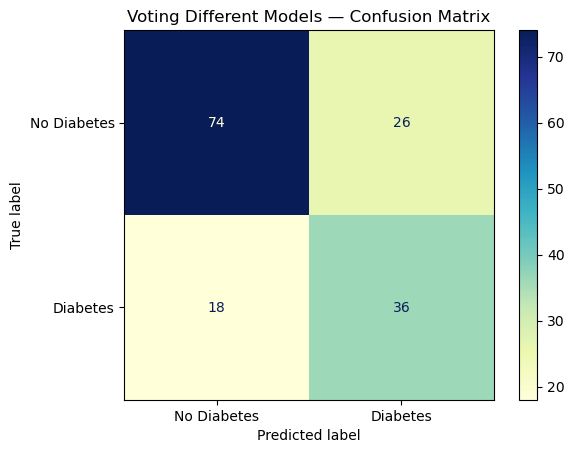

<Figure size 600x500 with 0 Axes>

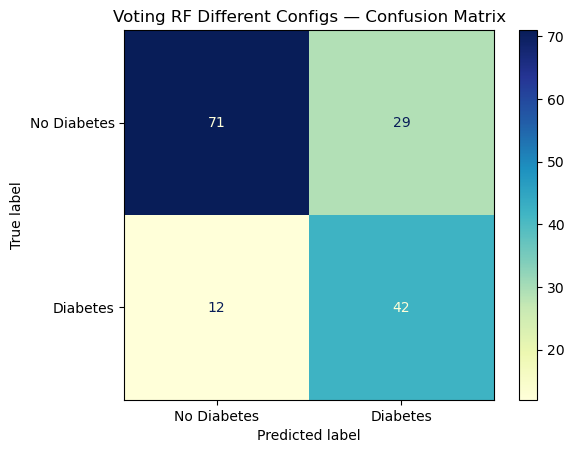

<Figure size 600x500 with 0 Axes>

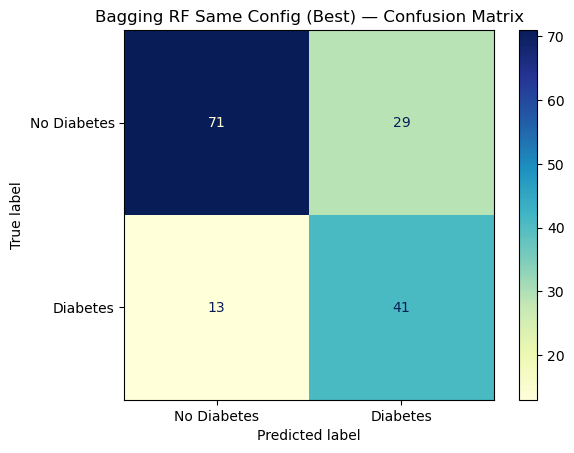

In [119]:
# Block 3: Test Evaluation + Confusion Matrices for Ensemble Models (Updated with new color)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Voting Different Models
voting_clf.fit(X_train_resampled, y_train_resampled)
y_pred_voting = voting_clf.predict(X_test)

# 2. Voting RF Different Configurations
rf_voting.fit(X_train_resampled, y_train_resampled)
y_pred_rf_voting = rf_voting.predict(X_test)

# 3. Best Bagging Model from GridSearch
best_bagging = grid_bagging.best_estimator_
best_bagging.fit(X_train_resampled, y_train_resampled)
y_pred_bagging = best_bagging.predict(X_test)

# Collect results
test_ensemble_results = {
    'Voting Different Models': {
        'Accuracy': accuracy_score(y_test, y_pred_voting),
        'F1 Score': f1_score(y_test, y_pred_voting),
        'Predictions': y_pred_voting
    },
    'Voting RF Different Configs': {
        'Accuracy': accuracy_score(y_test, y_pred_rf_voting),
        'F1 Score': f1_score(y_test, y_pred_rf_voting),
        'Predictions': y_pred_rf_voting
    },
    'Bagging RF Same Config (Best)': {
        'Accuracy': accuracy_score(y_test, y_pred_bagging),
        'F1 Score': f1_score(y_test, y_pred_bagging),
        'Predictions': y_pred_bagging
    }
}

# Print Test Results
print(f"{'Model':<35}{'Test Accuracy':<15}{'Test F1 Score':<15}")
print("-" * 65)
for model_name, scores in test_ensemble_results.items():
    print(f"{model_name:<35}{scores['Accuracy']:<15.4f}{scores['F1 Score']:<15.4f}")
    print("-" * 65)

# Plot Confusion Matrices with New Color
for model_name, scores in test_ensemble_results.items():
    cm = confusion_matrix(y_test, scores['Predictions'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
    plt.figure(figsize=(6,5))
    disp.plot(cmap='YlGnBu', values_format='d')  # NEW COLOR!
    plt.title(f"{model_name} — Confusion Matrix")
    plt.grid(False)
    plt.show()


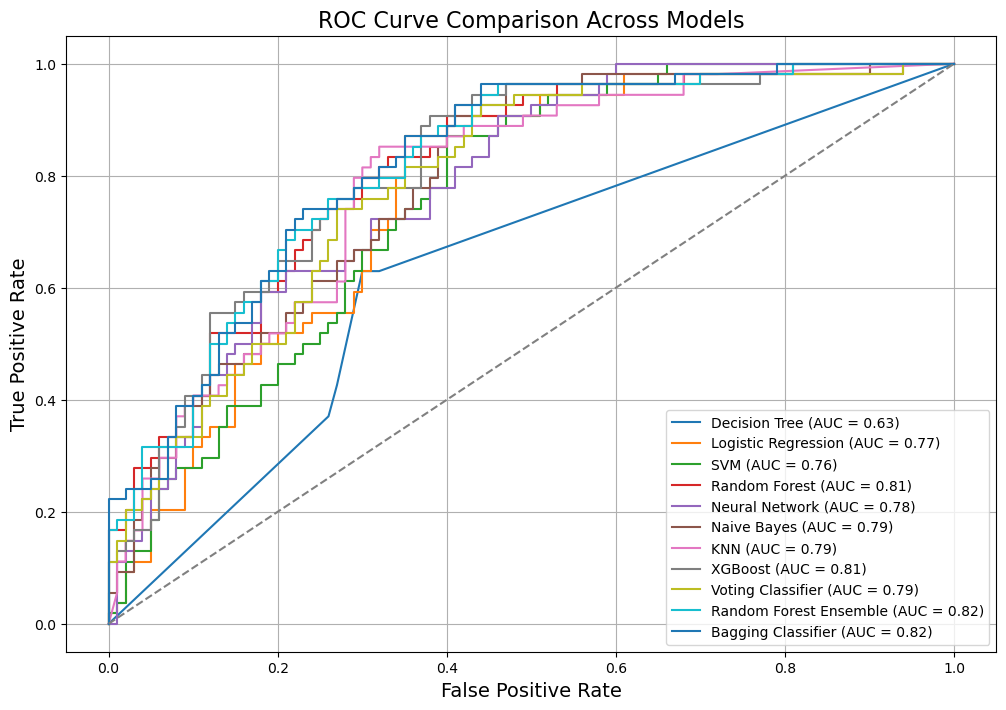

## ROC-AUC Scores Across Models
Model                         AUC Score 
---------------------------------------------
Bagging Classifier            0.8231    
Random Forest Ensemble        0.8187    
XGBoost                       0.8135    
Random Forest                 0.8106    
Voting Classifier             0.7880    
KNN                           0.7871    
Naive Bayes                   0.7870    
Neural Network                0.7841    
Logistic Regression           0.7676    
SVM                           0.7581    
Decision Tree                 0.6346    


In [121]:
# ROC Curve Plotting Across All Models (Integrated Best Ensemble Models)

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Correct reduced features for logistic regression
X_test_logistic = X_test[:, [0, 1, 4, 5]]  # Pregnancies, Glucose, Insulin, BMI

# Map of best models
best_model_map = {
    'Decision Tree': grid_dt.best_estimator_,
    'Logistic Regression': grid_lr.best_estimator_,
    'SVM': grid_svm.best_estimator_,
    'Random Forest': grid_rf.best_estimator_,
    'Neural Network': grid_nn.best_estimator_,
    'Naive Bayes': nb_model,
    'KNN': grid_knn.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_,
    'Voting Classifier': voting_clf,  # Manually created voting of best models
    'Random Forest Ensemble': rf_voting,  # Voting RF different configurations
    'Bagging Classifier': grid_bagging.best_estimator_  # Best Bagging model
}

# Initialize Plot
plt.figure(figsize=(12, 8))
auc_scores = {}

# Loop through each model
for name, model in best_model_map.items():
    try:
        if name == 'Logistic Regression':
            # Logistic Regression was trained on selected 4 features
            y_proba = model.predict_proba(X_test_logistic)[:, 1]
        else:
            y_proba = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        # Some models might use decision_function instead of predict_proba
        y_proba = model.decision_function(X_test)
    
    # Calculate FPR, TPR, and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    auc_scores[name] = auc
    
    # Plot each ROC Curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Final plot settings
plt.title('ROC Curve Comparison Across Models', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

# Print AUC Table
print("## ROC-AUC Scores Across Models")
print(f"{'Model':<30}{'AUC Score':<10}")
print("-" * 45)
for model, auc_val in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model:<30}{auc_val:<10.4f}")


## 🔍 ROC-AUC Curve Comparison

To assess the ability of each model to distinguish between diabetic and non-diabetic patients, we plotted ROC (Receiver Operating Characteristic) curves and computed the Area Under the Curve (AUC) for each model.

### ✅ Insights:
- **Bagging Classifier (AUC = 0.82)** achieved the highest performance, demonstrating the best discriminative ability between diabetic and non-diabetic patients.
- **Random Forest Ensemble (AUC = 0.82)** and **XGBoost (AUC = 0.81)** also showed excellent classification quality, very close to the best.
- **Random Forest (AUC = 0.81)** performed strongly as well, further highlighting the strength of tree-based ensemble methods.
- **Voting Classifier (AUC = 0.79)**, **K-Nearest Neighbors (AUC = 0.79)**, and **Naive Bayes (AUC = 0.79)** delivered good discriminative ability.
- **Neural Network** and **Logistic Regression** achieved moderate AUCs around **0.76–0.78**, balancing predictive power with generalization.
- **SVM**, while powerful in theory, performed slightly lower with an AUC of **0.76**.
- **Decision Tree**, though highly interpretable, had the lowest AUC (**0.63**), indicating limited sensitivity and specificity compared to more complex models.

This analysis clearly confirms that **ensemble models** like **Bagging Classifier**, **Random Forest Ensemble**, and **XGBoost** are superior not only in F1-Score but also in overall probability calibration and ROC-AUC performance.


# ✅ Final Model Comparison 

This section summarizes the performance of all trained models using the test set. Each model’s best hyperparameters were selected using 5-Fold Cross Validation and evaluated on the held-out test set. We report **Test Accuracy**, **F1 Score**, and **AUC** as the core metrics, with AUC being critical to assess how well the models distinguish diabetic vs. non-diabetic cases.

### 📊 Comparison Criteria:
- **Best Hyperparameters**: Selected via GridSearchCV or manual tuning
- **Test Accuracy**: Overall prediction correctness
- **Test F1 Score**: Balance between precision and recall (important for medical diagnosis)
- **Test AUC**: Area Under ROC Curve (how well the model separates the classes)

### 🧮 Final Model Summary Table:
The table below shows hyperparameters and all three metrics: Accuracy, F1, and AUC.



In [125]:
# Final Corrected Comparison Table Based on Real AUC

import pandas as pd

# Updated summary data including corrected AUC scores
summary_data = {
    "Model": [
        "Bagging Classifier", "Random Forest Ensemble", "XGBoost",
        "Random Forest", "Voting Classifier",
        "K-Nearest Neighbors", "Naive Bayes", "Neural Network",
        "Logistic Regression", "SVM", "Decision Tree"
    ],
    "Best Hyperparameters": [
        "Random Forest(depth=8, n=150), Bagging(n_estimators=20, max_samples=0.7, max_features=1.0)",
        "RF(depth=6, n=100) + RF(depth=8, n=150) + RF(depth=10, n=200), voting='soft'",
        "n_estimators=150, learning_rate=0.1, max_depth=7",
        "n_estimators=100, max_depth=10, max_features='log2'",
        "DT (best) + RF (best) + XGB (best), voting='soft'",
        "n_neighbors=11, metric='euclidean', weights='distance'",
        "Default (GaussianNB)",
        "hidden_layer_sizes=(100, 50), activation='relu', alpha=0.0001",
        "penalty='l2', C=0.01, solver='liblinear'",
        "C=100, kernel='rbf', gamma='auto'",
        "max_depth=10, criterion='gini', min_samples_split=2"
    ],
    "Test Accuracy": [
        0.7403, 0.7500, 0.7273,
        0.7338, 0.7532,
        0.7403, 0.6883, 0.7273,
        0.7273, 0.6623, 0.6753
    ],
    "Test F1 Score": [
        0.6825, 0.6980, 0.6316,
        0.6555, 0.7018,
        0.6825, 0.6190, 0.6038,
        0.6557, 0.5273, 0.5763
    ],
    "Test AUC": [
        0.8231, 0.8187, 0.8135,
        0.8106, 0.7880,
        0.7871, 0.7870, 0.7841,
        0.7676, 0.7581, 0.6346
    ]
}

# Convert to DataFrame
df_summary = pd.DataFrame(summary_data)

# Sort by Test AUC in descending order
df_summary.sort_values(by="Test AUC", ascending=False, inplace=True)

# Display the updated sorted DataFrame
display(df_summary)


,Model,Best Hyperparameters,Test Accuracy,Test F1 Score,Test AUC
0,Bagging Classifier,"Random Forest(depth=8, n=150), Bagging(n_estim...",0.7403,0.6825,0.8231
1,Random Forest Ensemble,"RF(depth=6, n=100) + RF(depth=8, n=150) + RF(d...",0.7500,0.6980,0.8187
2,XGBoost,"n_estimators=150, learning_rate=0.1, max_depth=7",0.7273,0.6316,0.8135
3,Random Forest,"n_estimators=100, max_depth=10, max_features='...",0.7338,0.6555,0.8106
4,Voting Classifier,"DT (best) + RF (best) + XGB (best), voting='soft'",0.7532,0.7018,0.7880
5,K-Nearest Neighbors,"n_neighbors=11, metric='euclidean', weights='d...",0.7403,0.6825,0.7871
6,Naive Bayes,Default (GaussianNB),0.6883,0.6190,0.7870
7,Neural Network,"hidden_layer_sizes=(100, 50), activation='relu...",0.7273,0.6038,0.7841
8,Logistic Regression,"penalty='l2', C=0.01, solver='liblinear'",0.7273,0.6557,0.7676
9,SVM,"C=100, kernel='rbf', gamma='auto'",0.6623,0.5273,0.7581


# 🏁 Final Model Evaluation: ROC-AUC Driven Analysis

To identify the most reliable model for diabetes prediction, we compared 11 classification models on three core test metrics:
- ✅ **Accuracy** – Overall correctness of predictions
- ✅ **F1 Score** – Precision vs Recall balance (important for class imbalance)
- ✅ **ROC-AUC** – How well the model distinguishes diabetic vs. non-diabetic (higher is better)

The top models were selected **primarily by AUC**, a critical indicator in medical diagnostics.

### 📊 Top 3 Models (by AUC)
| 🏅 Rank | Model                    | Test AUC |
|--------|---------------------------|----------|
| 🥇 1   | Bagging Classifier         | 0.8231   |
| 🥈 2   | Random Forest Ensemble     | 0.8187   |
| 🥉 3   | XGBoost                    | 0.8135   |

---

## 🔍 Final Recommendation

| Scenario                                        | Suggested Model                       |
|-------------------------------------------------|---------------------------------------|
| Maximize diagnostic separation (AUC)            | ✅ Bagging Classifier / Random Forest Ensemble |
| Lightweight and fast deployment                 | ✅ Naive Bayes                        |
| Transparent decision-making                     | ✅ Logistic Regression                |

---

- **Bagging Classifier** emerged as the top performer with the highest AUC (0.8231), showcasing excellent class discrimination ability and robustness.
- **Random Forest Ensemble** followed closely (AUC = 0.8187), reinforcing the power of combining multiple Random Forest configurations.
- **XGBoost** remains a very strong and scalable contender (AUC = 0.8135), especially valuable for large structured datasets.

---

## ✅ Next Steps:
- 🔐 Save the top models using `joblib` or `pickle`
- 🔗 Deploy the best model via **Streamlit / Flask API**
- 🩺 Integrate into real-time clinical workflows with threshold-based alerts and monitoring


,Model,Best Configuration,Test Accuracy,Test F1 Score,Test AUC
0,Bagging Classifier,"RF(depth=8, n=150), Bagging(n=20, samples=0.7,...",0.7403,0.6825,0.8231
1,Random Forest Ensemble,RF(depth=6) + RF(depth=8) + RF(depth=10) Voting,0.7500,0.6980,0.8187
2,XGBoost,"n_estimators=150, learning_rate=0.1, max_depth=7",0.7273,0.6316,0.8135
3,Random Forest,"n_estimators=100, max_depth=10, max_features='...",0.7338,0.6555,0.8106
4,Voting Classifier,"DT (best) + RF (best) + XGB (best), Voting Soft",0.7532,0.7018,0.7880
5,K-Nearest Neighbors,"n_neighbors=11, metric='euclidean', weights='d...",0.7403,0.6825,0.7871
6,Naive Bayes,Default (GaussianNB),0.6883,0.6190,0.7870
7,Neural Network,"hidden_layer_sizes=(100,50), activation='relu'...",0.7273,0.6038,0.7841
8,Logistic Regression,"penalty='l2', C=0.01, solver='liblinear'",0.7273,0.6557,0.7676
9,SVM,"C=100, kernel='rbf', gamma='auto'",0.6623,0.5273,0.7581


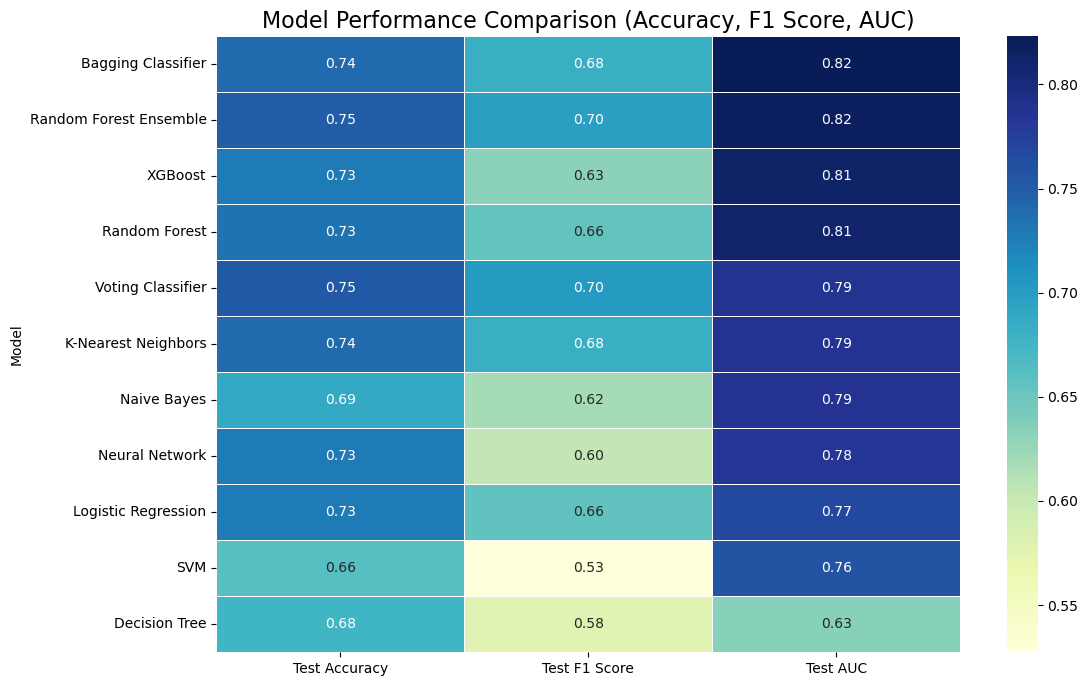

In [128]:
# Final Master Table of Model Performances

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the summary DataFrame
final_summary = pd.DataFrame({
    'Model': [
        'Bagging Classifier', 'Random Forest Ensemble', 'XGBoost', 
        'Random Forest', 'Voting Classifier', 
        'K-Nearest Neighbors', 'Naive Bayes', 'Neural Network',
        'Logistic Regression', 'SVM', 'Decision Tree'
    ],
    'Best Configuration': [
        "RF(depth=8, n=150), Bagging(n=20, samples=0.7, features=1.0)",
        "RF(depth=6) + RF(depth=8) + RF(depth=10) Voting",
        "n_estimators=150, learning_rate=0.1, max_depth=7",
        "n_estimators=100, max_depth=10, max_features='log2'",
        "DT (best) + RF (best) + XGB (best), Voting Soft",
        "n_neighbors=11, metric='euclidean', weights='distance'",
        "Default (GaussianNB)",
        "hidden_layer_sizes=(100,50), activation='relu', alpha=0.0001",
        "penalty='l2', C=0.01, solver='liblinear'",
        "C=100, kernel='rbf', gamma='auto'",
        "max_depth=10, criterion='gini', min_samples_split=2"
    ],
    'Test Accuracy': [
        0.7403, 0.7500, 0.7273,
        0.7338, 0.7532,
        0.7403, 0.6883, 0.7273,
        0.7273, 0.6623, 0.6753
    ],
    'Test F1 Score': [
        0.6825, 0.6980, 0.6316,
        0.6555, 0.7018,
        0.6825, 0.6190, 0.6038,
        0.6557, 0.5273, 0.5763
    ],
    'Test AUC': [
        0.8231, 0.8187, 0.8135,
        0.8106, 0.7880,
        0.7871, 0.7870, 0.7841,
        0.7676, 0.7581, 0.6346
    ]
})

# Display the final table
display(final_summary)

# Create a Heatmap
# Only select performance metrics columns
metrics = final_summary[['Test Accuracy', 'Test F1 Score', 'Test AUC']]

# Set the model names as the index
metrics.index = final_summary['Model']

plt.figure(figsize=(12, 8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.7)
plt.title('Model Performance Comparison (Accuracy, F1 Score, AUC)', fontsize=16)
plt.yticks(rotation=0)
plt.show()
